In [28]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [29]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setup Config

In [30]:
# set up config
model_train_date_str = "2009-01-01"
train_test_period_months = 108
oot_period_months = 12
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] = config["model_train_date"] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
 'model_train_date_str': '2009-01-01',
 'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
 'oot_period_months': 12,
 'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
 'train_test_period_months': 108,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)}


Label Store

In [ ]:
# connect to label store - use Spark
# read all parquet directories
label_store_path = "datamart/gold/label_store/"
parquet_dirs = [os.path.join(label_store_path, d) for d in os.listdir(label_store_path) 
                if d.endswith('.parquet')]

print(f"Reading {len(parquet_dirs)} parquet directories with Spark...")

# read all parquet files using Spark
label_store_sdf = spark.read.parquet(*parquet_dirs)

print(f"Label store count: {label_store_sdf.count()}")
label_store_sdf.printSchema()
label_store_sdf.show(5)

Reading 120 parquet files with pandas...
  Progress: 0/120
  Progress: 20/120
  Progress: 40/120
  Progress: 60/120
  Progress: 80/120
  Progress: 100/120
Label store shape: (101766, 3)
Columns: ['encounter_id', 'label', 'snapshot_date']

First few rows:
   encounter_id  label snapshot_date
0       2278392      0    1999-01-01
1        149190      0    1999-01-02
2         64410      0    1999-01-03
3        500364      0    1999-01-04
4         16680      0    1999-01-05


In [ ]:
# filter labels by date range using Spark
labels_sdf = label_store_sdf.filter(
    (col("snapshot_date") >= config["train_test_start_date"]) & 
    (col("snapshot_date") <= config["oot_end_date"])
)

print(f"Filtered labels: {labels_sdf.count()} records")
print(f"Date range: {config['train_test_start_date']} to {config['oot_end_date']}")

Filtered labels: 101766 records
Date range: 1999-01-01 00:00:00 to 2008-12-31 00:00:00


Get features

In [ ]:
# connect to feature store - use Spark
feature_store_path = "datamart/gold/feature_store/"
parquet_dirs = [os.path.join(feature_store_path, d) for d in os.listdir(feature_store_path) 
                if d.endswith('.parquet')]

print(f"Reading {len(parquet_dirs)} parquet directories with Spark...")

# read all parquet files using Spark
features_store_sdf = spark.read.parquet(*parquet_dirs)

print(f"Feature store count: {features_store_sdf.count()}")
features_store_sdf.printSchema()
features_store_sdf.show(5)

Reading 120 parquet files with pandas...
  Progress: 0/120
  Progress: 20/120
  Progress: 40/120
  Progress: 60/120
  Progress: 80/120
  Progress: 100/120
Feature store shape: (101766, 19)
Columns: ['encounter_id', 'race_AfricanAmerican', 'race_Caucasian', 'race_Asian', 'race_Hispanic', 'is_female', 'age_midpoint', 'admission_severity_score', 'admission_source_risk_score', 'poor_glucose_control', 'metformin_ord', 'insulin_ord', 'diabetesMed', 'severity_x_visits', 'medication_density', 'diag_1', 'diag_2', 'diag_3', 'snapshot_date']

First few rows:
   encounter_id  race_AfricanAmerican  race_Caucasian  race_Asian  \
0       2278392                     0               1           0   
1        149190                     0               1           0   
2         64410                     1               0           0   
3        500364                     0               1           0   
4         16680                     0               1           0   

   race_Hispanic  is_female  ag

In [ ]:
# filter features by date range using Spark
features_sdf = features_store_sdf.filter(
    (col("snapshot_date") >= config["train_test_start_date"]) & 
    (col("snapshot_date") <= config["oot_end_date"])
)

print(f"Filtered features: {features_sdf.count()} records")
print(f"Date range: {config['train_test_start_date']} to {config['oot_end_date']}")

Filtered features: 101766 records
Date range: 1999-01-01 00:00:00 to 2008-12-31 00:00:00


In [ ]:
# join labels and features using Spark
data_sdf = labels_sdf.join(
    features_sdf, 
    on=["encounter_id", "snapshot_date"], 
    how="inner"
)

print(f"Joined data count: {data_sdf.count()}")
data_sdf.show(5)

Joined data shape: (101766, 20)


,encounter_id,label,snapshot_date,race_AfricanAmerican,race_Caucasian,race_Asian,race_Hispanic,is_female,age_midpoint,admission_severity_score,admission_source_risk_score,poor_glucose_control,metformin_ord,insulin_ord,diabetesMed,severity_x_visits,medication_density,diag_1,diag_2,diag_3
0,2278392,0,1999-01-01,0,1,0,0,1,5,0,1,0,0,0,0,0,0.023810,250.83,?,?
1,149190,0,1999-01-02,0,1,0,0,1,15,3,2,0,0,2,1,0,0.022059,276,250.01,255
2,64410,0,1999-01-03,1,0,0,0,1,25,3,2,0,0,0,1,3,0.041958,648,250,V27
3,500364,0,1999-01-04,0,1,0,0,0,35,3,2,0,0,2,1,0,0.016827,8,250.43,403
4,16680,0,1999-01-05,0,1,0,0,0,45,3,2,0,0,1,1,0,0.011161,197,157,250


In [ ]:
# split data into train - test - oot using Spark
oot_sdf = data_sdf.filter(
    (col("snapshot_date") >= config["oot_start_date"]) & 
    (col("snapshot_date") <= config["oot_end_date"])
)
train_test_sdf = data_sdf.filter(
    (col("snapshot_date") >= config["train_test_start_date"]) & 
    (col("snapshot_date") <= config["train_test_end_date"])
)

# Get feature columns (exclude meta and label columns, keep diag for feature engineering later)
all_cols = data_sdf.columns
feature_cols = [c for c in all_cols if c not in ["encounter_id", "snapshot_date", "label", "medical_specialty"]]

print(f"Feature columns: {feature_cols}")
print(f"Train-Test count: {train_test_sdf.count()}, OOT count: {oot_sdf.count()}")

# Split into train and test using Spark
train_sdf, test_sdf = train_test_sdf.randomSplit([config["train_test_ratio"], 1-config["train_test_ratio"]], seed=42)

print(f"Train: {train_sdf.count()}, Test: {test_sdf.count()}, OOT: {oot_sdf.count()}")

# Check label distribution in each set
train_label_dist = train_sdf.groupBy("label").count().collect()
test_label_dist = test_sdf.groupBy("label").count().collect()
oot_label_dist = oot_sdf.groupBy("label").count().collect()

print("\nLabel distribution:")
print(f"Train: {train_label_dist}")
print(f"Test: {test_label_dist}")
print(f"OOT: {oot_label_dist}")

X_train 73507
X_test 18377
X_oot 9882
y_train 73507 0.11
y_test 18377 0.11
y_oot 9882 0.11


,race_AfricanAmerican,race_Caucasian,race_Asian,race_Hispanic,is_female,age_midpoint,admission_severity_score,admission_source_risk_score,poor_glucose_control,metformin_ord,insulin_ord,diabetesMed,severity_x_visits,medication_density
61906,0,1,0,0,1,55,3,2,0,0,0,1,0,0.036014
85321,0,1,0,0,1,65,3,2,0,0,1,1,0,0.012516
58055,1,0,0,0,1,35,3,2,1,1,1,1,0,0.016807
50229,0,1,0,0,0,75,3,2,0,1,0,1,0,0.012478
91328,0,1,0,0,0,95,2,1,0,0,1,1,0,0.028409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34325,0,1,0,0,0,75,2,2,0,0,1,1,0,0.030612
89560,0,1,0,0,1,85,3,2,0,0,0,1,2,0.225000
37332,0,1,0,0,1,65,1,1,0,1,1,1,0,0.078947
69043,0,1,0,0,1,95,0,2,1,0,1,1,0,0.022447


In [ ]:
# Convert Spark DataFrames to pandas for model training
print("Converting Spark DataFrames to pandas...")
train_pdf = train_sdf.toPandas()
test_pdf = test_sdf.toPandas()
oot_pdf = oot_sdf.toPandas()

print(f"Train shape: {train_pdf.shape}, Test shape: {test_pdf.shape}, OOT shape: {oot_pdf.shape}")

# Prepare X and y
X_train = train_pdf[feature_cols]
y_train = train_pdf["label"]
X_test = test_pdf[feature_cols]
y_test = test_pdf["label"]
X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]

print(f"\nX_train: {X_train.shape}, y_train mean: {y_train.mean():.3f}")
print(f"X_test: {X_test.shape}, y_test mean: {y_test.mean():.3f}")
print(f"X_oot: {X_oot.shape}, y_oot mean: {y_oot.mean():.3f}")

X_train_processed 73507
X_test_processed 18377
X_oot_processed 9882


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.688727,0.817462,0.538927,-0.451234,-0.484063,-0.455021,-0.214538,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-0.062040,0.817462,0.538927,-0.451234,0.708443,-0.455021,-0.451925,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,-1.942099,0.817462,0.538927,1.850401,0.708443,-0.455021,-0.408576,1.0,0.0,0.0,0.0,1.0,1.0,1.0
3,0.564646,0.817462,0.538927,1.850401,-0.484063,-0.455021,-0.452308,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.818019,-0.132910,-0.879589,-0.451234,0.708443,-0.455021,-0.291367,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73502,0.564646,-0.132910,0.538927,-0.451234,0.708443,-0.455021,-0.269111,0.0,1.0,0.0,0.0,0.0,0.0,1.0
73503,1.191332,0.817462,0.538927,-0.451234,-0.484063,0.126645,1.694617,0.0,1.0,0.0,0.0,1.0,0.0,1.0
73504,-0.062040,-1.083283,-0.879589,1.850401,0.708443,-0.455021,0.219176,0.0,1.0,0.0,0.0,1.0,0.0,1.0
73505,1.818019,-2.033656,0.538927,-0.451234,0.708443,-0.455021,-0.351600,0.0,1.0,0.0,0.0,1.0,1.0,1.0


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
import pprint

# --------------------------------------------------------
# Define the Logistic Regression model
# --------------------------------------------------------
log_reg = LogisticRegression(
    solver='liblinear',  # works well for small/medium datasets & L1/L2 penalty
    random_state=88,
    max_iter=1000
)

# --------------------------------------------------------
# Define the hyperparameter search space
# --------------------------------------------------------
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'class_weight': [None, 'balanced']
}

# --------------------------------------------------------
# Create a scorer based on AUC
# --------------------------------------------------------
auc_scorer = make_scorer(roc_auc_score)

# --------------------------------------------------------
# Randomized search with cross-validation
# --------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1  # avoid unicode error in Chinese path
)

# --------------------------------------------------------
# Fit the model on TRAIN data
# --------------------------------------------------------
random_search.fit(X_train_processed, y_train)

# --------------------------------------------------------
# Show best parameters and cross-val AUC
# --------------------------------------------------------
print("\nBest parameters found:")
pprint.pprint(random_search.best_params_)
print("Best cross-validation AUC score: ", random_search.best_score_)

# --------------------------------------------------------
# Evaluate best model on TRAIN / TEST / OOT
# --------------------------------------------------------
best_model = random_search.best_estimator_

# TRAIN
y_pred_train = best_model.predict_proba(X_train_processed)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_train)

# TEST
y_pred_test = best_model.predict_proba(X_test_processed)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_test)

# OOT
y_pred_oot = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc = roc_auc_score(y_oot, y_pred_oot)

# --------------------------------------------------------
# Print all AUC + GINI scores
# --------------------------------------------------------
print("\nAUC Scores:")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test  AUC: {test_auc:.4f}")
print(f"OOT   AUC: {oot_auc:.4f}")

print("\nGINI Scores:")
print(f"Train GINI: {2*train_auc - 1:.4f}")
print(f"Test  GINI: {2*test_auc - 1:.4f}")
print(f"OOT   GINI: {2*oot_auc - 1:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found:
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Best cross-validation AUC score:  0.5747472846241662

AUC Scores:
Train AUC: 0.6053
Test  AUC: 0.6090
OOT   AUC: 0.6122

GINI Scores:
Train GINI: 0.2107
Test  GINI: 0.2179
OOT   GINI: 0.2244


In [39]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)


                        Feature  Coefficient
5                  age_midpoint     0.299123
13           medication_density     0.267897
7   admission_source_risk_score     0.076079
8          poor_glucose_control     0.071308
0          race_AfricanAmerican     0.065030
1                race_Caucasian     0.047146
10                  insulin_ord     0.031161
11                  diabetesMed     0.019805
6      admission_severity_score     0.007916
2                    race_Asian    -0.008637
4                     is_female    -0.014284
3                 race_Hispanic    -0.068359
12            severity_x_visits    -0.080773
9                 metformin_ord    -0.144958


### Feature Engineering - Diagnosis Codes


In [ ]:
# For feature engineering, convert the full joined Spark DataFrame to pandas
# This includes the diagnosis codes (diag_1, diag_2, diag_3) which we'll use
print("Converting full joined data to pandas for feature engineering...")
data_full_pdf = data_sdf.toPandas()
print(f"Total records: {len(data_full_pdf)}")
print(f"Columns: {data_full_pdf.columns.tolist()}")


Using existing joined data
Total records: 101766
Columns: ['encounter_id', 'label', 'snapshot_date', 'race_AfricanAmerican', 'race_Caucasian', 'race_Asian', 'race_Hispanic', 'is_female', 'age_midpoint', 'admission_severity_score', 'admission_source_risk_score', 'poor_glucose_control', 'metformin_ord', 'insulin_ord', 'diabetesMed', 'severity_x_visits', 'medication_density', 'diag_1', 'diag_2', 'diag_3']


In [ ]:
# diagnosis groupings based on ICD-9 ranges
def map_diag_to_category(diag):
    if pd.isna(diag) or diag == '?':
        return 'unknown'
    
    diag_str = str(diag).strip()
    
    # try numeric first
    try:
        diag_num = float(diag_str)
        if 390 <= diag_num < 460:
            return 'circulatory'
        elif 460 <= diag_num < 520:
            return 'respiratory'
        elif 250 <= diag_num < 251:
            return 'diabetes'
        elif 520 <= diag_num < 580:
            return 'digestive'
        elif 800 <= diag_num < 1000:
            return 'injury'
        elif 140 <= diag_num < 240:
            return 'neoplasms'
        elif 710 <= diag_num < 740:
            return 'musculoskeletal'
        elif 580 <= diag_num < 630:
            return 'genitourinary'
        else:
            return 'other'
    except:
        # handle V codes, E codes
        if diag_str.startswith('V'):
            return 'supplementary_v'
        elif diag_str.startswith('E'):
            return 'supplementary_e'
        else:
            return 'other'

# apply to all three diag columns
for i in [1, 2, 3]:
    data_full_pdf[f'diag_{i}_category'] = data_full_pdf[f'diag_{i}'].apply(map_diag_to_category)

# count high-risk diagnoses
high_risk_categories = ['circulatory', 'diabetes', 'injury']
data_full_pdf['high_risk_diag_count'] = data_full_pdf[[f'diag_{i}_category' for i in [1,2,3]]].apply(
    lambda row: sum([1 for val in row if val in high_risk_categories]), axis=1
)

data_full_pdf[['diag_1', 'diag_1_category', 'diag_2_category', 'diag_3_category', 'high_risk_diag_count']].head(10)


,diag_1,diag_1_category,diag_2_category,diag_3_category,high_risk_diag_count
0,250.83,diabetes,unknown,unknown,1
1,276,other,diabetes,other,1
2,648,other,diabetes,supplementary_v,1
3,8,other,diabetes,circulatory,2
4,197,neoplasms,neoplasms,diabetes,1
5,414,circulatory,circulatory,diabetes,3
6,414,circulatory,circulatory,supplementary_v,2
7,428,circulatory,respiratory,diabetes,2
8,398,circulatory,circulatory,other,2
9,434,circulatory,neoplasms,respiratory,1


In [ ]:
# one-hot encode primary diagnosis category
diag_dummies = pd.get_dummies(data_full_pdf['diag_1_category'], prefix='diag1')
data_full_pdf = pd.concat([data_full_pdf, diag_dummies], axis=1)

# add circulatory system flag (known high readmission risk)
data_full_pdf['has_circulatory'] = (
    (data_full_pdf['diag_1_category'] == 'circulatory') | 
    (data_full_pdf['diag_2_category'] == 'circulatory') | 
    (data_full_pdf['diag_3_category'] == 'circulatory')
).astype(int)

# multiple comorbidities flag
data_full_pdf['multiple_systems'] = (data_full_pdf[['diag_1_category', 'diag_2_category', 'diag_3_category']].nunique(axis=1) == 3).astype(int)

print(f"new feature count: {len([c for c in data_full_pdf.columns if c.startswith('diag')])}")
print(f"circulatory cases: {data_full_pdf['has_circulatory'].sum()} ({data_full_pdf['has_circulatory'].mean()*100:.1f}%)")


new feature count: 18
circulatory cases: 58672 (57.7%)


### Data Quality Checks


In [ ]:
# basic validation checks before modeling
validation_results = {}

# check for nulls in key features
key_features = ['age_midpoint', 'admission_severity_score', 'poor_glucose_control', 'label']
for feat in key_features:
    null_pct = data_full_pdf[feat].isna().mean() * 100
    validation_results[f'{feat}_null_pct'] = null_pct
    assert null_pct < 5, f"{feat} has {null_pct:.2f}% nulls"

# check label distribution
label_dist = data_full_pdf['label'].value_counts(normalize=True)
validation_results['label_positive_rate'] = label_dist.get(1, 0)
assert 0.05 < label_dist.get(1, 0) < 0.30, "label distribution out of expected range"

# check for data leakage - no future dates
assert (data_full_pdf['snapshot_date'] <= config["oot_end_date"]).all(), "future dates detected"

# check numeric ranges
assert (data_full_pdf['age_midpoint'] >= 0).all() and (data_full_pdf['age_midpoint'] <= 100).all(), "age out of range"

# check for duplicates
dup_count = data_full_pdf.duplicated(subset=['encounter_id', 'snapshot_date']).sum()
validation_results['duplicate_records'] = dup_count
assert dup_count == 0, f"found {dup_count} duplicate records"

print("✓ All validation checks passed")
for k, v in validation_results.items():
    print(f"  {k}: {v}")


✓ All validation checks passed
  age_midpoint_null_pct: 0.0
  admission_severity_score_null_pct: 0.0
  poor_glucose_control_null_pct: 0.0
  label_null_pct: 0.0
  label_positive_rate: 0.11159915885462728
  duplicate_records: 0


In [ ]:
# statistical baseline for drift detection later
baseline_stats = {}

numeric_features = data_pdf.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['encounter_id', 'label']]

for feat in numeric_features:
    baseline_stats[feat] = {
        'mean': data_pdf[feat].mean(),
        'std': data_pdf[feat].std(),
        'min': data_pdf[feat].min(),
        'max': data_pdf[feat].max(),
        'q25': data_pdf[feat].quantile(0.25),
        'q50': data_pdf[feat].quantile(0.50),
        'q75': data_pdf[feat].quantile(0.75)
    }

# save for later drift monitoring
import json
with open('baseline_stats.json', 'w') as f:
    json.dump({k: {kk: float(vv) for kk, vv in v.items()} for k, v in baseline_stats.items()}, f, indent=2)

print(f"saved baseline stats for {len(baseline_stats)} features")


saved baseline stats for 17 features


### Prepare Training Data with New Features


In [ ]:
# split with new features
oot_pdf = data_full_pdf[(data_full_pdf['snapshot_date'] >= config["oot_start_date"]) & 
                         (data_full_pdf['snapshot_date'] <= config["oot_end_date"])]
train_test_pdf = data_full_pdf[(data_full_pdf['snapshot_date'] >= config["train_test_start_date"]) & 
                                (data_full_pdf['snapshot_date'] <= config["train_test_end_date"])]

# define feature columns - exclude metadata and original diag columns
exclude_cols = ["encounter_id", "snapshot_date", "label", "diag_1", "diag_2", "diag_3", 
                "diag_1_category", "diag_2_category", "diag_3_category"]
feature_cols = [c for c in train_test_pdf.columns if c not in exclude_cols]

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]

X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], 
    train_test_pdf["label"], 
    test_size=1 - config["train_test_ratio"],
    random_state=88,
    stratify=train_test_pdf["label"]
)

print(f'Features: {len(feature_cols)}')
print(f'Train: {X_train.shape[0]:,} samples, bad rate: {y_train.mean():.3f}')
print(f'Test: {X_test.shape[0]:,} samples, bad rate: {y_test.mean():.3f}')
print(f'OOT: {X_oot.shape[0]:,} samples, bad rate: {y_oot.mean():.3f}')


Features: 29
Train: 73,507 samples, bad rate: 0.111
Test: 18,377 samples, bad rate: 0.111
OOT: 9,882 samples, bad rate: 0.114


### XGBoost Model Training


In [46]:
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 3, 5, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    tree_method='hist'
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    scoring=auc_scorer,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1  # avoid unicode error in Chinese path
)

xgb_search.fit(X_train, y_train)

print("\nXGBoost best params:")
pprint.pprint(xgb_search.best_params_)
print(f"CV AUC: {xgb_search.best_score_:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=8, subsample=0.9; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=8, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=8, subsample=0.9; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, 

In [47]:
xgb_best = xgb_search.best_estimator_

y_pred_train_xgb = xgb_best.predict_proba(X_train)[:, 1]
y_pred_test_xgb = xgb_best.predict_proba(X_test)[:, 1]
y_pred_oot_xgb = xgb_best.predict_proba(X_oot)[:, 1]

xgb_train_auc = roc_auc_score(y_train, y_pred_train_xgb)
xgb_test_auc = roc_auc_score(y_test, y_pred_test_xgb)
xgb_oot_auc = roc_auc_score(y_oot, y_pred_oot_xgb)

print("\n" + "="*50)
print("XGBoost Performance")
print("="*50)
print(f"\nAUC:")
print(f"  Train: {xgb_train_auc:.4f}")
print(f"  Test:  {xgb_test_auc:.4f}")
print(f"  OOT:   {xgb_oot_auc:.4f}")

print(f"\nGINI:")
print(f"  Train: {2*xgb_train_auc - 1:.4f}")
print(f"  Test:  {2*xgb_test_auc - 1:.4f}")
print(f"  OOT:   {2*xgb_oot_auc - 1:.4f}")

# additional metrics
from sklearn.metrics import average_precision_score, precision_recall_curve

pr_auc_test = average_precision_score(y_test, y_pred_test_xgb)
pr_auc_oot = average_precision_score(y_oot, y_pred_oot_xgb)

print(f"\nPR-AUC (better for imbalanced):")
print(f"  Test: {pr_auc_test:.4f}")
print(f"  OOT:  {pr_auc_oot:.4f}")



XGBoost Performance

AUC:
  Train: 0.6358
  Test:  0.6262
  OOT:   0.6344

GINI:
  Train: 0.2716
  Test:  0.2525
  OOT:   0.2687

PR-AUC (better for imbalanced):
  Test: 0.1812
  OOT:  0.1868



Top 20 Features:
                 feature  importance
       severity_x_visits    0.327085
            age_midpoint    0.049540
             diabetesMed    0.048764
           metformin_ord    0.044039
   diag1_musculoskeletal    0.042937
       diag1_circulatory    0.040188
          diag1_diabetes    0.035202
            diag1_injury    0.032665
       diag1_respiratory    0.028384
   diag1_supplementary_v    0.028338
     diag1_genitourinary    0.027680
admission_severity_score    0.027673
      medication_density    0.026392
             insulin_ord    0.022973
    poor_glucose_control    0.021212
               is_female    0.020463
              race_Asian    0.020071
             diag1_other    0.019607
        multiple_systems    0.018882
         has_circulatory    0.017264


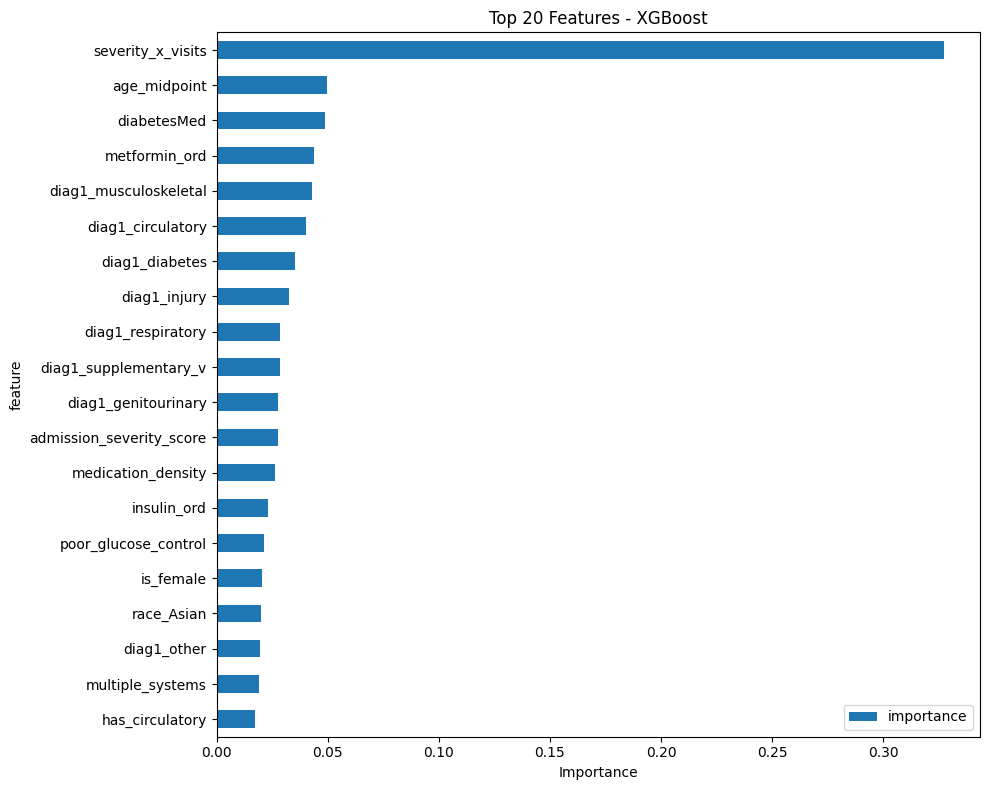

In [48]:
# feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features:")
print(xgb_importance.head(20).to_string(index=False))

# plot top features
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
xgb_importance.head(top_n).plot(x='feature', y='importance', kind='barh', ax=ax)
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### LightGBM Model Training


In [49]:
# pip install lightgbm if needed
try:
    import lightgbm as lgb
    
    lgb_params = {
        'num_leaves': [15, 31, 63],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_samples': [5, 10, 20],
        'scale_pos_weight': [1, 3, 5, 8]
    }
    
    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=42,
        verbosity=-1
    )
    
    lgb_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=lgb_params,
        scoring=auc_scorer,
        n_iter=20,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=1  # avoid unicode error in Chinese path
    )
    
    lgb_search.fit(X_train, y_train)
    
    print("\nLightGBM best params:")
    pprint.pprint(lgb_search.best_params_)
    print(f"CV AUC: {lgb_search.best_score_:.4f}")
    
except ImportError:
    print("LightGBM not installed, skipping...")


c:\Python\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=5, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=5, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_sam

In [50]:
if 'lgb_search' in locals():
    lgb_best = lgb_search.best_estimator_
    
    y_pred_train_lgb = lgb_best.predict_proba(X_train)[:, 1]
    y_pred_test_lgb = lgb_best.predict_proba(X_test)[:, 1]
    y_pred_oot_lgb = lgb_best.predict_proba(X_oot)[:, 1]
    
    lgb_train_auc = roc_auc_score(y_train, y_pred_train_lgb)
    lgb_test_auc = roc_auc_score(y_test, y_pred_test_lgb)
    lgb_oot_auc = roc_auc_score(y_oot, y_pred_oot_lgb)
    
    print("\n" + "="*50)
    print("LightGBM Performance")
    print("="*50)
    print(f"\nAUC:")
    print(f"  Train: {lgb_train_auc:.4f}")
    print(f"  Test:  {lgb_test_auc:.4f}")
    print(f"  OOT:   {lgb_oot_auc:.4f}")
    
    print(f"\nGINI:")
    print(f"  Train: {2*lgb_train_auc - 1:.4f}")
    print(f"  Test:  {2*lgb_test_auc - 1:.4f}")
    print(f"  OOT:   {2*lgb_oot_auc - 1:.4f}")



LightGBM Performance

AUC:
  Train: 0.6490
  Test:  0.6309
  OOT:   0.6327

GINI:
  Train: 0.2979
  Test:  0.2618
  OOT:   0.2654


### Model Comparison


In [51]:
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Train_AUC': [train_auc, xgb_train_auc],
    'Test_AUC': [test_auc, xgb_test_auc],
    'OOT_AUC': [oot_auc, xgb_oot_auc],
    'Train_GINI': [2*train_auc-1, 2*xgb_train_auc-1],
    'Test_GINI': [2*test_auc-1, 2*xgb_test_auc-1],
    'OOT_GINI': [2*oot_auc-1, 2*xgb_oot_auc-1]
})

if 'lgb_oot_auc' in locals():
    comparison = pd.concat([comparison, pd.DataFrame({
        'Model': ['LightGBM'],
        'Train_AUC': [lgb_train_auc],
        'Test_AUC': [lgb_test_auc],
        'OOT_AUC': [lgb_oot_auc],
        'Train_GINI': [2*lgb_train_auc-1],
        'Test_GINI': [2*lgb_test_auc-1],
        'OOT_GINI': [2*lgb_oot_auc-1]
    })], ignore_index=True)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison.to_string(index=False))

# identify best model
best_idx = comparison['OOT_GINI'].idxmax()
print(f"\nBest model by OOT GINI: {comparison.loc[best_idx, 'Model']}")
print(f"OOT GINI: {comparison.loc[best_idx, 'OOT_GINI']:.4f}")



MODEL COMPARISON
              Model  Train_AUC  Test_AUC  OOT_AUC  Train_GINI  Test_GINI  OOT_GINI
Logistic Regression   0.605350  0.608954 0.612220    0.210699   0.217909  0.224441
            XGBoost   0.635800  0.626250 0.634355    0.271600   0.252499  0.268710
           LightGBM   0.648971  0.630886 0.632682    0.297941   0.261772  0.265363

Best model by OOT GINI: XGBoost
OOT GINI: 0.2687


### Drift Detection


In [52]:
# check for distribution drift between train and OOT
from scipy.stats import ks_2samp

drift_results = []

for feat in feature_cols:
    if feat in X_train.columns and feat in X_oot.columns:
        train_vals = X_train[feat].dropna()
        oot_vals = X_oot[feat].dropna()
        
        # KS test
        ks_stat, p_value = ks_2samp(train_vals, oot_vals)
        
        # PSI calculation
        def calc_psi(expected, actual, bins=10):
            breakpoints = np.linspace(0, 100, bins+1)
            expected_percents = np.percentile(expected, breakpoints)
            
            expected_counts = np.histogram(expected, bins=expected_percents)[0]
            actual_counts = np.histogram(actual, bins=expected_percents)[0]
            
            expected_percents = expected_counts / len(expected)
            actual_percents = actual_counts / len(actual)
            
            # avoid log(0)
            expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
            actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
            
            psi = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
            return psi
        
        try:
            psi = calc_psi(train_vals, oot_vals)
        except:
            psi = np.nan
        
        drift_results.append({
            'feature': feat,
            'ks_stat': ks_stat,
            'p_value': p_value,
            'psi': psi,
            'drift_detected': (p_value < 0.05) or (psi > 0.1)
        })

drift_df = pd.DataFrame(drift_results).sort_values('psi', ascending=False)

print("Features with Drift (PSI > 0.1 or KS p-value < 0.05):")
print(drift_df[drift_df['drift_detected']].head(15).to_string(index=False))

drift_count = drift_df['drift_detected'].sum()
print(f"\nTotal features with drift: {drift_count} / {len(feature_cols)} ({drift_count/len(feature_cols)*100:.1f}%)")


Features with Drift (PSI > 0.1 or KS p-value < 0.05):
                    feature  ks_stat  p_value      psi  drift_detected
admission_source_risk_score 0.015395 0.031855 0.001122            True

Total features with drift: 1 / 29 (3.4%)


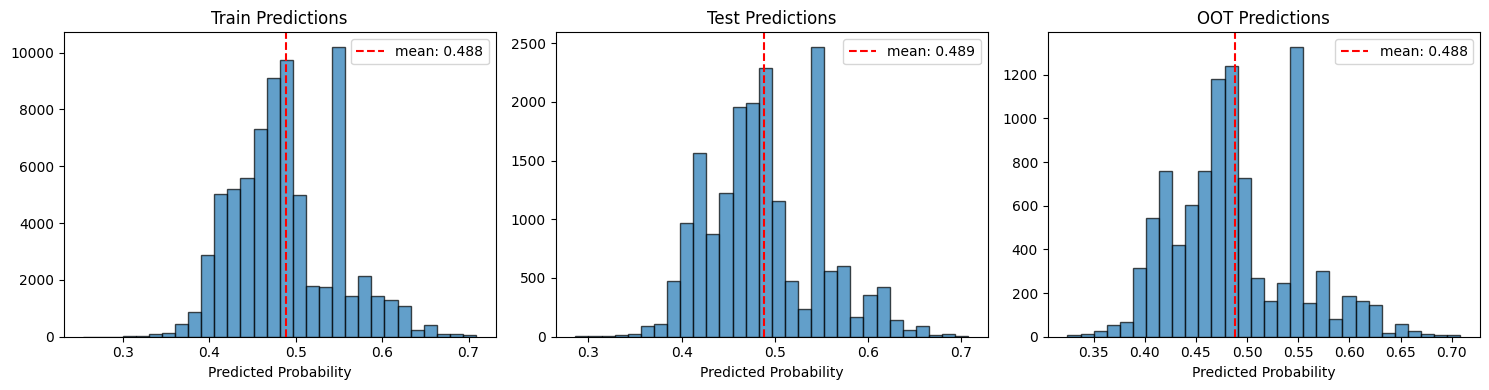


Prediction mean shift:
  Train: 0.4884
  Test:  0.4887
  OOT:   0.4884
  Shift (Train→OOT): 0.0000


In [53]:
# prediction distribution drift
pred_train_dist = np.histogram(y_pred_train_xgb, bins=20, range=(0,1))[0] / len(y_pred_train_xgb)
pred_test_dist = np.histogram(y_pred_test_xgb, bins=20, range=(0,1))[0] / len(y_pred_test_xgb)
pred_oot_dist = np.histogram(y_pred_oot_xgb, bins=20, range=(0,1))[0] / len(y_pred_oot_xgb)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_pred_train_xgb, bins=30, alpha=0.7, edgecolor='black')
axes[0].set_title('Train Predictions')
axes[0].set_xlabel('Predicted Probability')
axes[0].axvline(y_pred_train_xgb.mean(), color='r', linestyle='--', label=f'mean: {y_pred_train_xgb.mean():.3f}')
axes[0].legend()

axes[1].hist(y_pred_test_xgb, bins=30, alpha=0.7, edgecolor='black')
axes[1].set_title('Test Predictions')
axes[1].set_xlabel('Predicted Probability')
axes[1].axvline(y_pred_test_xgb.mean(), color='r', linestyle='--', label=f'mean: {y_pred_test_xgb.mean():.3f}')
axes[1].legend()

axes[2].hist(y_pred_oot_xgb, bins=30, alpha=0.7, edgecolor='black')
axes[2].set_title('OOT Predictions')
axes[2].set_xlabel('Predicted Probability')
axes[2].axvline(y_pred_oot_xgb.mean(), color='r', linestyle='--', label=f'mean: {y_pred_oot_xgb.mean():.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nPrediction mean shift:")
print(f"  Train: {y_pred_train_xgb.mean():.4f}")
print(f"  Test:  {y_pred_test_xgb.mean():.4f}")
print(f"  OOT:   {y_pred_oot_xgb.mean():.4f}")
print(f"  Shift (Train→OOT): {abs(y_pred_oot_xgb.mean() - y_pred_train_xgb.mean()):.4f}")


### Save Model and Artifacts


In [54]:
# save best XGBoost model
model_filename = f'xgboost_model_{config["model_train_date_str"]}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(xgb_best, f)

print(f"Model saved: {model_filename}")

# save feature list
with open('feature_columns.json', 'w') as f:
    json.dump(feature_cols, f, indent=2)

# save model metadata
metadata = {
    'model_type': 'XGBoost',
    'train_date': config["model_train_date_str"],
    'train_period': f'{config["train_test_start_date"]} to {config["train_test_end_date"]}',
    'oot_period': f'{config["oot_start_date"]} to {config["oot_end_date"]}',
    'n_features': len(feature_cols),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'oot_samples': len(X_oot),
    'train_auc': float(xgb_train_auc),
    'test_auc': float(xgb_test_auc),
    'oot_auc': float(xgb_oot_auc),
    'train_gini': float(2*xgb_train_auc - 1),
    'test_gini': float(2*xgb_test_auc - 1),
    'oot_gini': float(2*xgb_oot_auc - 1),
    'best_params': xgb_search.best_params_
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print("Metadata saved: model_metadata.json")

# save drift report
drift_df.to_csv('drift_report.csv', index=False)
print("Drift report saved: drift_report.csv")


Model saved: xgboost_model_2009-01-01.pkl
Metadata saved: model_metadata.json
Drift report saved: drift_report.csv


In [ ]:
# save model to model bank with versioning
import os
import pickle
import json
from datetime import datetime

# check if model exists
if 'xgb_best' not in locals():
    raise ValueError("❌ xgb_best not found. Please run Cell 25 (XGBoost Training) first!")

# create model bank directory
model_bank_dir = "model_bank"
os.makedirs(model_bank_dir, exist_ok=True)

# generate version timestamp
version_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version = f"v_{version_timestamp}"

# create version subdirectory
version_dir = os.path.join(model_bank_dir, model_version)
os.makedirs(version_dir, exist_ok=True)

# save XGBoost model
model_path = os.path.join(version_dir, "xgboost_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(xgb_best, f)

# save LightGBM model if available
if 'lgb_best' in locals():
    lgb_model_path = os.path.join(version_dir, "lightgbm_model.pkl")
    with open(lgb_model_path, 'wb') as f:
        pickle.dump(lgb_best, f)

# save feature columns
feature_path = os.path.join(version_dir, "feature_columns.json")
with open(feature_path, 'w') as f:
    json.dump(feature_cols, f, indent=2)

# save comprehensive model metadata
model_bank_metadata = {
    'version': model_version,
    'created_at': version_timestamp,
    'model_type': 'XGBoost',
    'training_config': {
        'train_date': config["model_train_date_str"],
        'train_period_start': str(config["train_test_start_date"]),
        'train_period_end': str(config["train_test_end_date"]),
        'oot_period_start': str(config["oot_start_date"]),
        'oot_period_end': str(config["oot_end_date"]),
        'train_test_ratio': config["train_test_ratio"]
    },
    'data_info': {
        'n_features': len(feature_cols),
        'train_samples': int(len(X_train)),
        'test_samples': int(len(X_test)),
        'oot_samples': int(len(X_oot)),
        'train_positive_rate': float(y_train.mean()),
        'test_positive_rate': float(y_test.mean()),
        'oot_positive_rate': float(y_oot.mean())
    },
    'performance': {
        'xgboost': {
            'train_auc': float(xgb_train_auc),
            'test_auc': float(xgb_test_auc),
            'oot_auc': float(xgb_oot_auc),
            'train_gini': float(2*xgb_train_auc - 1),
            'test_gini': float(2*xgb_test_auc - 1),
            'oot_gini': float(2*xgb_oot_auc - 1),
            'best_params': xgb_search.best_params_
        }
    },
    'feature_engineering': {
        'diagnosis_features': True,
        'high_risk_categories': ['circulatory', 'diabetes', 'injury'],
        'composite_features': ['severity_x_visits', 'medication_density']
    }
}

# add LightGBM performance if available
if 'lgb_oot_auc' in locals():
    model_bank_metadata['performance']['lightgbm'] = {
        'train_auc': float(lgb_train_auc),
        'test_auc': float(lgb_test_auc),
        'oot_auc': float(lgb_oot_auc),
        'train_gini': float(2*lgb_train_auc - 1),
        'test_gini': float(2*lgb_test_auc - 1),
        'oot_gini': float(2*lgb_oot_auc - 1),
        'best_params': lgb_search.best_params_
    }

metadata_path = os.path.join(version_dir, "model_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(model_bank_metadata, f, indent=2, default=str)

# save baseline statistics
baseline_path = os.path.join(version_dir, "baseline_stats.json")
with open(baseline_path, 'w') as f:
    json.dump({k: {kk: float(vv) for kk, vv in v.items()} for k, v in baseline_stats.items()}, f, indent=2)

# save drift report
drift_path = os.path.join(version_dir, "drift_report.csv")
drift_df.to_csv(drift_path, index=False)

# save monitoring thresholds (will be defined in next cell)
# thresholds_path = os.path.join(version_dir, "monitoring_thresholds.json")

# create model registry file (for tracking all versions)
registry_file = os.path.join(model_bank_dir, "model_registry.json")
if os.path.exists(registry_file):
    with open(registry_file, 'r') as f:
        registry = json.load(f)
else:
    registry = {'models': []}

# add current version to registry
registry['models'].append({
    'version': model_version,
    'created_at': version_timestamp,
    'model_type': 'XGBoost',
    'oot_gini': float(2*xgb_oot_auc - 1),
    'oot_auc': float(xgb_oot_auc),
    'n_features': len(feature_cols),
    'path': version_dir
})

# keep only latest 10 versions in registry
registry['models'] = sorted(registry['models'], key=lambda x: x['created_at'], reverse=True)[:10]

with open(registry_file, 'w') as f:
    json.dump(registry, f, indent=2)


### Monitoring Thresholds


In [55]:
# define monitoring thresholds for production
monitoring_thresholds = {
    'performance': {
        'min_oot_gini': float(2*xgb_oot_auc - 1) * 0.90,  # alert if drops below 90% of baseline
        'min_oot_auc': float(xgb_oot_auc) * 0.90
    },
    'drift': {
        'max_psi': 0.2,  # moderate drift
        'critical_psi': 0.5,  # severe drift
        'max_ks_stat': 0.15
    },
    'predictions': {
        'max_pred_shift': 0.05,  # max shift in mean prediction
        'min_pred_rate': float(y_pred_oot_xgb.mean()) * 0.80,
        'max_pred_rate': float(y_pred_oot_xgb.mean()) * 1.20
    },
    'data_quality': {
        'max_null_pct': 5.0,
        'min_records_per_month': 1000
    }
}

with open('monitoring_thresholds.json', 'w') as f:
    json.dump(monitoring_thresholds, f, indent=2)

print("Monitoring Thresholds:")
print(json.dumps(monitoring_thresholds, indent=2))

# check current status against thresholds
alerts = []

if (2*xgb_oot_auc - 1) < monitoring_thresholds['performance']['min_oot_gini']:
    alerts.append("⚠ OOT GINI below threshold")

high_drift_features = drift_df[drift_df['psi'] > monitoring_thresholds['drift']['max_psi']]
if len(high_drift_features) > 0:
    alerts.append(f"⚠ {len(high_drift_features)} features with high drift (PSI > 0.2)")

pred_shift = abs(y_pred_oot_xgb.mean() - y_pred_train_xgb.mean())
if pred_shift > monitoring_thresholds['predictions']['max_pred_shift']:
    alerts.append(f"⚠ Prediction distribution shifted by {pred_shift:.4f}")

if len(alerts) > 0:
    print("\n" + "="*50)
    print("ALERTS")
    print("="*50)
    for alert in alerts:
        print(alert)
else:
    print("\n✓ All monitoring checks passed")


Monitoring Thresholds:
{
  "performance": {
    "min_oot_gini": 0.24183871567526585,
    "min_oot_auc": 0.5709193578376329
  },
  "drift": {
    "max_psi": 0.2,
    "critical_psi": 0.5,
    "max_ks_stat": 0.15
  },
  "predictions": {
    "max_pred_shift": 0.05,
    "min_pred_rate": 0.390742564201355,
    "max_pred_rate": 0.5861138463020324
  },
  "data_quality": {
    "max_null_pct": 5.0,
    "min_records_per_month": 1000
  }
}

✓ All monitoring checks passed


### Summary


In [56]:
print("\n" + "="*70)
print("TRAINING PIPELINE COMPLETE")
print("="*70)

print(f"\nModel: XGBoost")
print(f"Training period: {config['train_test_start_date'].date()} to {config['train_test_end_date'].date()}")
print(f"OOT period: {config['oot_start_date'].date()} to {config['oot_end_date'].date()}")
print(f"Features: {len(feature_cols)} (including {len([c for c in feature_cols if 'diag' in c])} diagnosis-related)")

print(f"\nPerformance:")
print(f"  OOT GINI: {2*xgb_oot_auc - 1:.4f}")
print(f"  OOT AUC:  {xgb_oot_auc:.4f}")
print(f"  PR-AUC:   {pr_auc_oot:.4f}")

print(f"\nArtifacts saved:")
print(f"  - {model_filename}")
print(f"  - feature_columns.json")
print(f"  - model_metadata.json")
print(f"  - baseline_stats.json")
print(f"  - drift_report.csv")
print(f"  - monitoring_thresholds.json")

print(f"\nNext steps:")
print(f"  1. Review feature importance and drift analysis")
print(f"  2. Deploy model to inference API")
print(f"  3. Set up monitoring dashboard")
print(f"  4. Schedule monthly retraining")



TRAINING PIPELINE COMPLETE

Model: XGBoost
Training period: 1999-01-01 to 2007-12-31
OOT period: 2008-01-01 to 2008-12-31
Features: 29 (including 13 diagnosis-related)

Performance:
  OOT GINI: 0.2687
  OOT AUC:  0.6344
  PR-AUC:   0.1868

Artifacts saved:
  - xgboost_model_2009-01-01.pkl
  - feature_columns.json
  - model_metadata.json
  - baseline_stats.json
  - drift_report.csv
  - monitoring_thresholds.json

Next steps:
  1. Review feature importance and drift analysis
  2. Deploy model to inference API
  3. Set up monitoring dashboard
  4. Schedule monthly retraining
